<a href="https://colab.research.google.com/github/banno-0720/learning_TensorFlow/blob/main/VAE_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

# Data Preparation

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [4]:
len(dataset)

70000

In [5]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [6]:
train_dataset = (
    dataset
    .shuffle(buffer_size=1024,reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [7]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Modeling

## Sampling

In [8]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

## Encoder

In [9]:
encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(LATENT_DIM)(x)
log_var = Dense(LATENT_DIM)(x)

z = Sampling()([mean,log_var])

encoder_model = Model(encoder_inputs,[z,mean,log_var], name='encoder')
encoder_model.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

## Decoder

In [10]:
latent_inputs = Input(shape=(LATENT_DIM,))

x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model = Model(latent_inputs,decoder_output,name='decoder')
decoder_model.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

## Overall VAE Model

In [11]:
vae_input = Input(shape=(28,28,1), name="vae_input")
z,_,_ = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input,output,name="vae")
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vae_input (InputLayer)               │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ [(None, 2), (None, 2),      │          69,076 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │          65,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,165 (524.08 KB)

 Trainable params: 134,165 (524.08 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
for i in range(3):
  print(vae.layers[i])

<InputLayer name=vae_input, built=True>
<Functional name=encoder, built=True>
<Functional name=decoder, built=True>


# Training

In [13]:
OPTIMIZER = Adam(learning_rate=1e-3)
EPOCHS = 20

In [14]:
def custom_loss(y_true,y_pred,mean,log_var):

  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))

  loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1-tf.math.square(mean)-tf.math.exp(log_var)), axis = 1))

  return loss_rec+loss_reg

In [15]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z,mean,log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true, y_pred, mean, log_var)

  partial_derivatives = recorder.gradient(loss,vae.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives,vae.trainable_weights))
  return loss

In [16]:
def neuralearn(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))

    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training Loss is:', loss)
  print('Training Complete!')

In [17]:
neuralearn(EPOCHS)

Training starts for epoch number 1
Training Loss is: tf.Tensor(194.67673, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss is: tf.Tensor(162.53964, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss is: tf.Tensor(166.90462, shape=(), dtype=float32)
Training starts for epoch number 4
Training Loss is: tf.Tensor(164.92722, shape=(), dtype=float32)
Training starts for epoch number 5
Training Loss is: tf.Tensor(156.9689, shape=(), dtype=float32)
Training starts for epoch number 6
Training Loss is: tf.Tensor(153.24153, shape=(), dtype=float32)
Training starts for epoch number 7
Training Loss is: tf.Tensor(158.47273, shape=(), dtype=float32)
Training starts for epoch number 8
Training Loss is: tf.Tensor(150.01749, shape=(), dtype=float32)
Training starts for epoch number 9
Training Loss is: tf.Tensor(149.30693, shape=(), dtype=float32)
Training starts for epoch number 10
Training Loss is: tf.Tensor(157.7649, shape=(), dtype=float32)
Training st

## Overriding train_step method

In [18]:
class VAE(tf.keras.Model):
  def __init__(self,encoder_model, decoder_model):
    super(VAE,self).__init__()
    self.encoder=encoder_model
    self.decoder=decoder_model
    self.loss_tracker=tf.keras.metrics.Mean(name='loss')
  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self,x_batch):
    with tf.GradientTape() as recorder:
      z,mean,log_var = encoder_model(x_batch)
      y_pred = decoder_model(z)
      y_true = x_batch
      loss = custom_loss(y_true,y_pred, mean, log_var)

    partial_derivatives = recorder.gradient(loss,self.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {'loss':self.loss_tracker.result()}

In [19]:
model=VAE(encoder_model,decoder_model)
model.compile(optimizer=OPTIMIZER)
model.fit(train_dataset, epochs=20,batch_size=128,)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 149.8103
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 149.6423
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 149.5299
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 149.2827
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 149.1970
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 148.8624
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 148.7398
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 148.3983
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 148.4883
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 148.2748
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 148.2054
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 147.9133
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 147.8198
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 147.7132
Epoch 15/20
547/547 ━━━━━━━

# Testing

In [20]:
scale = 1
n = 16

In [21]:
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)

In [22]:
print(grid_x,grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

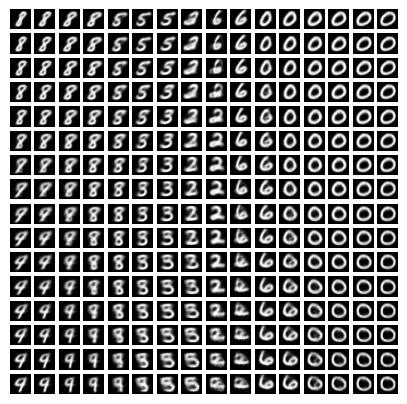

In [23]:
plt.figure(figsize=(5,5))
k = 0
for i in grid_x:
  for j in grid_y:
    ax = plt.subplot(n,n,k+1)

    input = tf.constant([[i,j]])
    out=vae.layers[2].predict(input)[0][...,0]
    plt.imshow(out,cmap="Greys_r")
    plt.axis("off")
    k += 1

In [24]:
print(vae.layers[2].predict(tf.constant([[-1,1]]))[0][...,0].shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
(28, 28)


In [25]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train,-1).astype("float32") / 255

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


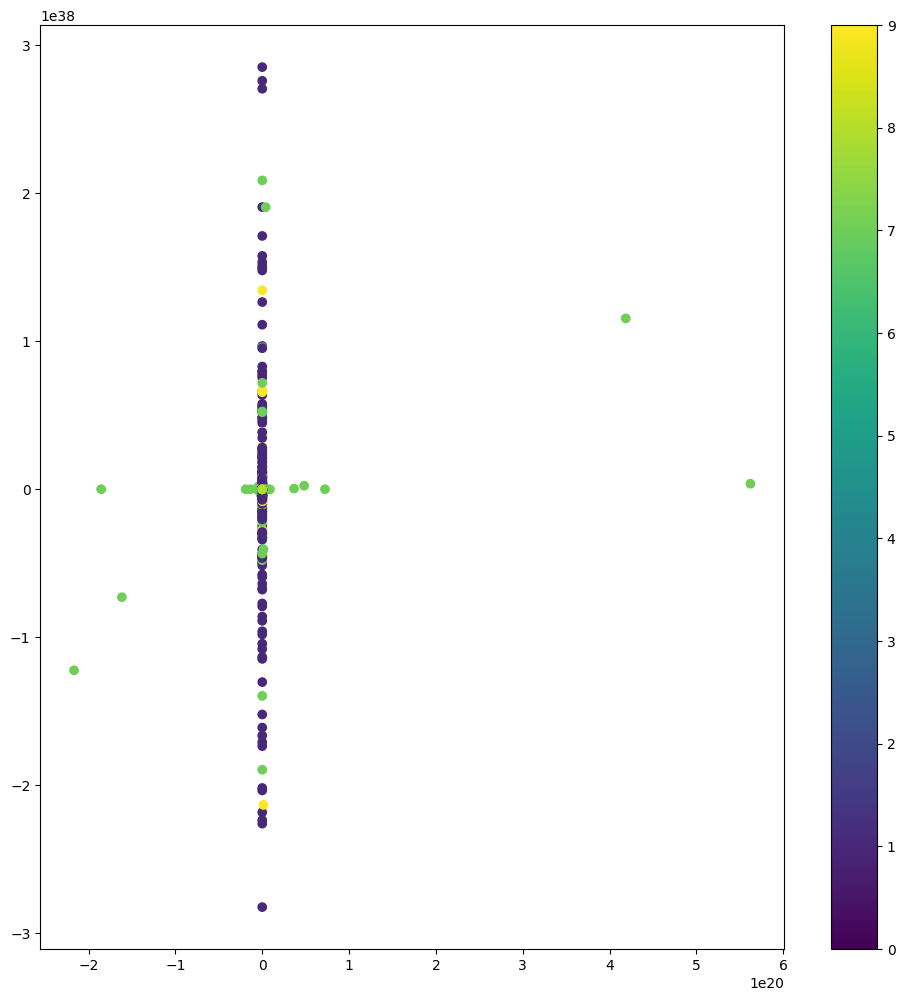

In [26]:
z,_,_=vae.layers[1].predict(x_train)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=y_train)
plt.colorbar()
plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


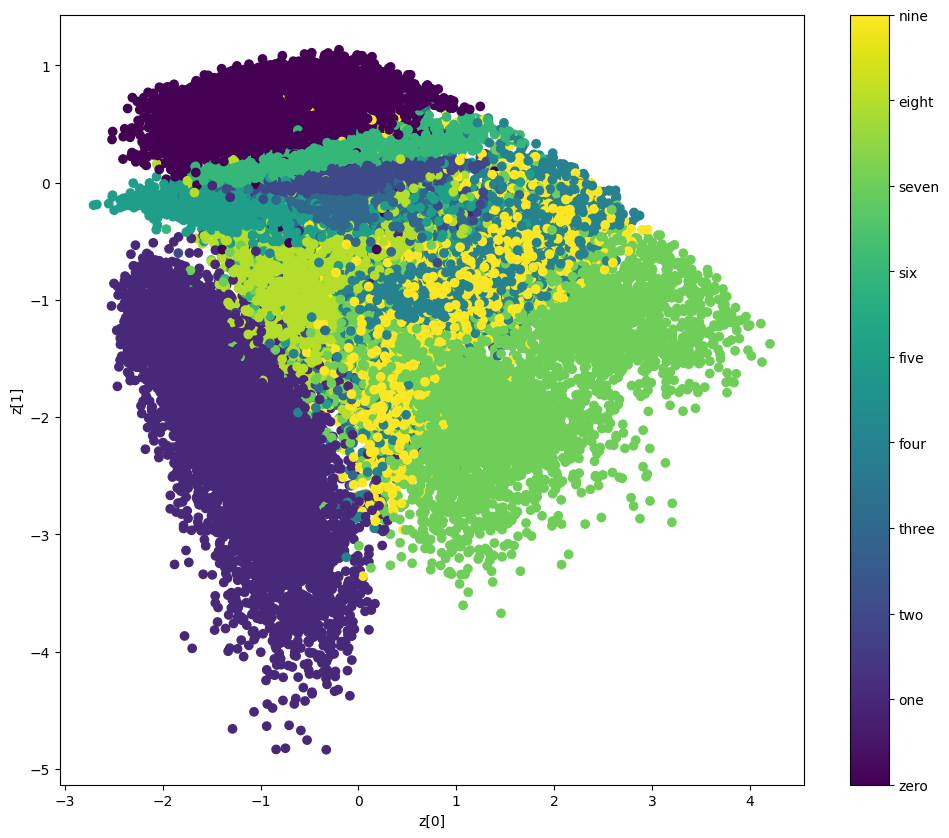

In [28]:
def plot_label_clusters(encoder, decoder, data, test_lab):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize =(12, 10))
    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
    cbar = plt.colorbar(sc, ticks = range(10))
    cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


labels = {0    :"zero",
1:    "one",
2:    "two",
3:    "three",
4:    "four",
5:    "five",
6:    "six",
7:    "seven",
8:    "eight",
9:    "nine"}

(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder_model, decoder_model, x_train, y_train)